# NLP модель сопоставления вариантов названия школ для GoProtect

Заказчик компания GoProtect.\
Исполнитель Сергей Решетов.


**Описание проекта:**\
Сервис  “Мой Чемпион” помогает спортивным школам фигурного катания, тренерам мониторить результаты своих подопечных и планировать дальнейшее развитие спортсменов.

**Проблема:**\
При сборе данных одна и та же школа может быть записана по разному, например, "Республика Татарстан, СШОР ФСО Авиатор" и "Республика Татарстан, МБУ СШОР ФСО Авиатор г.Казань".
  
**Цель:**\
Создать решение для стандартизации названий спортивных школ. Нужно сопоставить варианты эталонному названию из предоставленной таблицы.

#### Задачи

Изучить данные – эталонные названия СШ и варианты пользовательского ввода\
Подготовить обучающий набор данных на основе эталонного датасета\
Создать модель для подбора наиболее вероятных названий при ошибочном вводе\
Создать функцию (класс, модуль) для применения в сервисе\
возможность выбора количества кандидатов\
вывод в виде списка словарей\
Протестировать решение\
Проанализировать результат и предложить варианты улучшения\
Создать документацию\
описание признаков\
какая модель используется\
как оценивается качество\
инструкция по запуску (применению)\
Готовый проект предоставить в виде репозитория на гитхабе\
Демо приложение streamlit (* опционально)\


## Загрузка данных

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from sentence_transformers import SentenceTransformer

/opt/anaconda3/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
reference_schools = pd.read_csv('data_02_match_school/Школы.csv')
df = pd.read_csv('data_02_match_school/Примерное написание.csv')

Изучим карту эталонных названий школ `reference_schools`.

In [3]:
reference_schools.info()
reference_schools.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   school_id  306 non-null    int64 
 1   name       306 non-null    object
 2   region     306 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.3+ KB


,school_id,name,region
0,1,Авангард,Московская область
1,2,Авангард,Ямало-Ненецкий АО
2,3,Авиатор,Республика Татарстан
3,4,Аврора,Санкт-Петербург
4,5,Ice Dream / Айс Дрим,Санкт-Петербург


In [4]:
print('В карте школ:')
print('Уникальных id:', reference_schools['school_id'].nunique())
print('Уникальных названий школ без привязки к городу:', reference_schools['name'].nunique())
print('Из', reference_schools['region'].nunique(), 'городов.')

В карте школ:
Уникальных id: 306
Уникальных названий школ без привязки к городу: 263
Из 74 городов.


Количество наименований школ 263 шт. говорит о наличии одно названия в разных регионах.

Изучим обучающую выборку школ с вариантами и ошибками в названии из `df`.

In [5]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895 entries, 0 to 894
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   school_id  895 non-null    int64 
 1   name       895 non-null    object
dtypes: int64(1), object(1)
memory usage: 14.1+ KB


,school_id,name
0,1836,"ООО ""Триумф"""
1,1836,"Москва, СК ""Триумф"""
2,610,"СШОР ""Надежда Губернии"
3,610,"Саратовская область, ГБУСО ""СШОР ""Надежда Губе..."
4,609,"""СШ ""Гвоздика"""


In [6]:
print('Уникальных id:', df['school_id'].nunique())
print('Неявных дубликатов названий:', df.shape[0] - df['school_id'].nunique())

Уникальных id: 264
Неявных дубликатов названий: 631


В датасете 895 записи, в которой 264 уникальной школы с разными вариантами названий. Отдельного поля с городом нет, он находится внутри имени.

## Предобработка данных

Создадим в карте эталонных наименований школ столбец содержаний регион и название, так как в обучающие выборке они содержаться в одном столбце.

In [7]:
reference_schools['region_name'] = reference_schools['region'] + ' ' +  reference_schools['name']
reference_schools.head()

,school_id,name,region,region_name
0,1,Авангард,Московская область,Московская область Авангард
1,2,Авангард,Ямало-Ненецкий АО,Ямало-Ненецкий АО Авангард
2,3,Авиатор,Республика Татарстан,Республика Татарстан Авиатор
3,4,Аврора,Санкт-Петербург,Санкт-Петербург Аврора
4,5,Ice Dream / Айс Дрим,Санкт-Петербург,Санкт-Петербург Ice Dream / Айс Дрим


Посмотрим на топ 10 школ, которые имеют наибольшее количество разных вариантов написания.

In [8]:
top_variance =  df.groupby('school_id').count().sort_values('name', ascending=False).head(15)
top_variance = top_variance.reset_index()
top_variance.columns = ['school_id', 'count']
top_variance = top_variance.merge(reference_schools, how='left', left_on='school_id', right_on='school_id')

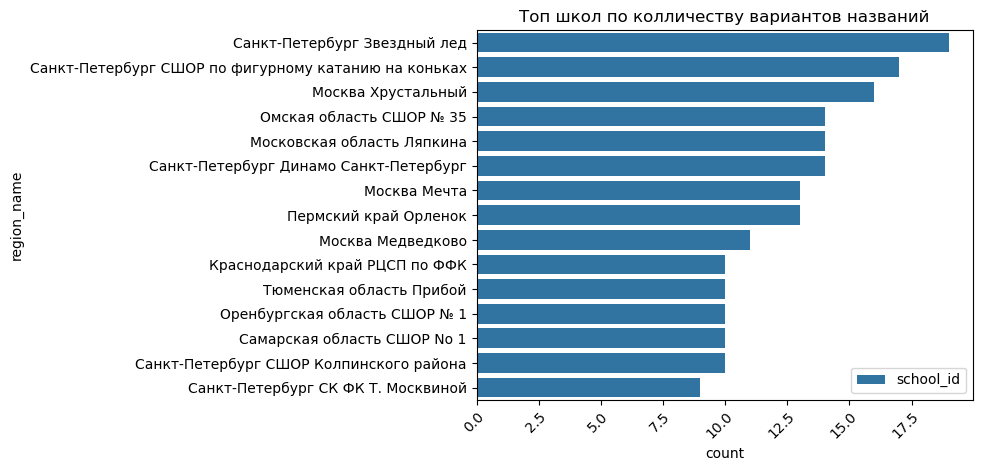

In [9]:
sns.barplot(top_variance, x = 'count', y = 'region_name', label = 'school_id', orient = 'h')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.title('Топ школ по колличеству вариантов названий')
plt.show()

Проведя ручную проверку эталонной таблицы, в ней было обнаружено большое количество неявных дубликатов.

In [10]:
reference_schools.sort_values('region')

,school_id,name,region,region_name
301,305,Прогресс,Алтайский край,Алтайский край Прогресс
21,22,Беломорец,Архангельская область,Архангельская область Беломорец
65,66,Каскад,Архангельская область,Архангельская область Каскад
158,159,Созвездие,Астраханская область,Астраханская область Созвездие
50,51,ДЮСШ по ЗВС,Белгородская область,Белгородская область ДЮСШ по ЗВС
...,...,...,...,...
18,19,Арктур,Ямало-Ненецкий АО,Ямало-Ненецкий АО Арктур
1,2,Авангард,Ямало-Ненецкий АО,Ямало-Ненецкий АО Авангард
75,76,Контакт,Ямало-Ненецкий АО,Ямало-Ненецкий АО Контакт
113,114,Новый уренгой,Ямало-Ненецкий АО,Ямало-Ненецкий АО Новый уренгой


Составим список кортежей дубликатов, где оставим первое значение, а остальные удалим.

In [11]:
dupl_id = [(239, 299), (171, 247), (32, 133), (36, 26), (251, 252), (186, 187), (37, 194), (67, 68), (200, 197, 202, 219), (155, 141), (289, 131), (208, 220), (296, 90), (236, 242), (99, 175), (234, 232), (195, 196), (295, 117), (95, 188), (297, 154), (48, 277)]

In [12]:
iter_dupl = iter(dupl_id)

In [13]:
#Функция вывода батча среза по дубликатам
def print_duplicates():
    display(df[df['school_id'].isin(next(iter_dupl)[:])])

In [14]:
print_duplicates()

,school_id,name
14,299,"РФСОО ""ФФККРК"""
144,239,"Республика Коми, РФСОО ФФКК РК"
145,239,Республика Коми/г. Ухта/ РФСОО ФФКК РК
146,239,"Республика Коми, РФСОО ""ФФКК РК"""


In [15]:
reference_schools[reference_schools['school_id'] == 202]

,school_id,name,region,region_name
201,202,СШОР по ФФК,Республика Мордовия,Республика Мордовия СШОР по ФФК


In [16]:
reference_schools[reference_schools['school_id'] == 197]

,school_id,name,region,region_name
196,197,СШОР по фигурному катанию на конька,Республика Мордовия,Республика Мордовия СШОР по фигурному катанию ...


Удалим дубли из эталонного и вариативного датасета.

In [17]:
dupl_id_list = [i for t in dupl_id for i in t[1:]]

In [18]:
reference_schools = reference_schools[~reference_schools['school_id'].isin(dupl_id_list)]
reference_schools = reference_schools.reset_index(drop=True)

Сохраним отфильтрованный эталонный файл на диск.

In [19]:
reference_schools.to_csv('data_02_match_school/reference_schools.csv', encoding='utf-8')

Заменим `school_id` в df в тех местах, где значение ссылалось на дубликат эталонных id.

In [20]:
for i in range(len(dupl_id)):
    df.loc[df['school_id'].isin([dupl_id[i][1]]), 'school_id'] = dupl_id[i][0]
    
df.loc[df['school_id'].isin([197, 202, 219]), 'school_id'] = 200

Оставим только текст и числа. Заменим вхождения ё на е.

In [21]:
df['name'] = (df['name']
              .replace(r'[^А-Яа-яёЁA-Za-z\s\d+]', ' ', regex=True)
              .replace('ё', 'е')
              .replace(r'\s+', ' ', regex=True)
              .str.strip())

Также сделаем обработку на новом столбце в `reference_schools`.

In [22]:
reference_schools['region_name'] = (reference_schools['region_name']
    .replace(r'[^А-Яа-яёЁA-Za-z\s\d+]', ' ', regex=True)
    .replace('ё', 'е')
    .replace(r'\s+', ' ', regex=True)
    .str.strip())

Удалим наиболее часто встречающиеся аббревиатуры без потери смысла. Список в дальнейшем можно пополнять. 

In [23]:
words_to_replace = ['No', 'ООО', 'ГБУСО', 'ФСО', 'ДО', 'МБУ', 'ОР', 'МАУ', 'ДЮЦ', 'АНО', 'ГБУ', 'ГУ', 'ТО', 'ГАУ', 'БУ', 'ГБПОУ']

In [24]:
df['name'] = df['name'].replace(words_to_replace, '', regex=True)
reference_schools['region_name'] = reference_schools['region_name'].replace(words_to_replace, '', regex=True)

Посчитаем дубли в вариативной выборке наименований.

In [25]:
df.duplicated().sum()

100

Найдено 100 полных дубликатов без применения машинного обучения, а только лишь с помощью ручной обработки. Удалим их.

In [26]:
df = df.drop_duplicates().reset_index(drop=True)

## Построение модели

In [27]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [28]:
corpus_embeddings = model.encode(reference_schools['region_name'], convert_to_tensor=True)

In [29]:
queries = model.encode(df['name'], convert_to_tensor=True)

In [30]:
top_k = min(1, len(corpus_embeddings))
ans = []

for query in df['name']:
    query_embedding = model.encode(query, convert_to_tensor=True)

    # We use cosine-similarity and torch.topk to find the highest 5 scores
    similarity_scores = model.similarity(query_embedding, corpus_embeddings)[0]
    scores, indices = torch.topk(similarity_scores, k=top_k)

    print("\nQuery:", query)
    print("Top 2 most similar sentences in corpus:")

    for score, idx in zip(scores, indices):
        print(reference_schools['region_name'].loc[int(idx)], "(Score: {:.4f})".format(score))
        ans.append({'corpus_id': int(idx), 'score': float(score), 'query': query})


Query:  Триумф
Top 2 most similar sentences in corpus:
Москва  Триумф (Score: 0.9079)

Query: Москва СК Триумф
Top 2 most similar sentences in corpus:
Москва  Триумф (Score: 0.9868)

Query: СШ Надежда Губернии
Top 2 most similar sentences in corpus:
Саратовская область СШ Надежда Губернии (Score: 0.9478)

Query: Саратовская область  СШ Надежда Губернии
Top 2 most similar sentences in corpus:
Саратовская область СШ Надежда Губернии (Score: 1.0000)

Query: СШ Гвоздика
Top 2 most similar sentences in corpus:
Москва ЦСКА (Score: 0.9003)

Query: СШ по ЗВС
Top 2 most similar sentences in corpus:
Пензенская область СШ по ЗВС (Score: 0.9148)

Query: Пензенская область СШ по ЗВС
Top 2 most similar sentences in corpus:
Пензенская область СШ по ЗВС (Score: 1.0000)

Query: Пензенская область   СШ по зимним видам спорта
Top 2 most similar sentences in corpus:
Калининградская область КО СШ по ЗВС (Score: 0.9647)

Query:  СетПоинт
Top 2 most similar sentences in corpus:
Москва  СетПоинт (Score: 0.91

In [31]:
df['pred_score'] = [ans[i]['score'] for i in range(len(ans))]
df['corpus_index'] = [ans[i]['corpus_id'] for i in range(len(ans))]

In [32]:
df = df.merge(reference_schools[['school_id', 'region_name']], how='left', left_on=['corpus_index'], right_index=True, suffixes=('', '_pred'))
df = df.drop('corpus_index', axis=1)
df = df.rename(columns={'region_name': 'name_pred'})
df

,school_id,name,pred_score,school_id_pred,name_pred
0,1836,Триумф,0.907905,1836,Москва Триумф
1,1836,Москва СК Триумф,0.986844,1836,Москва Триумф
2,610,СШ Надежда Губернии,0.947750,610,Саратовская область СШ Надежда Губернии
3,610,Саратовская область СШ Надежда Губернии,1.000000,610,Саратовская область СШ Надежда Губернии
4,609,СШ Гвоздика,0.900290,251,Москва ЦСКА
...,...,...,...,...,...
790,3,Республика Татарстан СШ Авиатор,0.989422,3,Республика Татарстан Авиатор
791,3,СШ Авиатор Республика Татарстан,0.956486,3,Республика Татарстан Авиатор
792,3,Республика Татарстан СШ Авиатор,0.989422,3,Республика Татарстан Авиатор
793,2,ЯНАО СШ Авангард,0.907309,2,Ямало Ненецкий АО Авангард


Выведем метрику точности модели.

In [33]:
(df['school_id'] == df['school_id_pred']).mean()

0.7257861635220125

In [34]:
reference_schools[reference_schools['school_id'] == 198]

,school_id,name,region,region_name
183,198,СШОР по фигурному катанию на коньках,Санкт-Петербург,Санкт Петербург СШ по фигурному катанию на кон...


In [35]:
reference_schools[reference_schools['school_id'] == 299]

,school_id,name,region,region_name


Выведем датасет в котором крайне высокое сходство названий, но при этом были сделаны ошибочные предсказания.

In [36]:
df.loc[(df['pred_score'] > 0.98) & (df['school_id'] != df['school_id_pred'])]

,school_id,name,pred_score,school_id_pred,name_pred
299,179,Краснодарский край КК СШ по ФКК и хоккею,0.984795,199,Краснодарский край СШ по ФКК
302,179,КК СШ по ФККиК Краснодарский край,0.986639,199,Краснодарский край СШ по ФКК
312,176,Вологодская область СШ по ЛВС,0.982430,195,Тверская область СШ по ЛВС
520,96,Москва Московская академия фигурного катания...,0.984327,10,Москва Академия синхронного катания на коньках
522,96,Москва Московская академия фигурного катания ...,0.986543,10,Москва Академия синхронного катания на коньках
523,96,Москва Московская академия фигурного катания,0.986956,21,Московская область Армия фигурного катания
774,10,Москва Академия синхронного катания,0.985699,20,Москва Армия фигурного катания


## Сохранение модели

In [37]:
with open('model/corpus_embeddings.npy', 'wb') as corpus:
    np.save(corpus, corpus_embeddings)

In [38]:
model.save('model')

## Выводы

Построена модель SentenceTransformer с весами 'paraphrase-MiniLM-L6-v2', которая дала точность на эталонных наименованиях школ более 72%.

Сложность состоит в подготовке данных, а именно распределению весов региона и названия школы. Например, модель путает `Краснодарский край КК СШ по ФКК и хоккею` и `Краснодарский край СШ по ФКК`. Название области имеет большой вес.

Решение данной проблемы представляется в 2 этапа:
1. Найти схожесть региона;
2. Внутри региона найти схожесть наименования школы.

Таким образом во втором этапе поиск будет происходить только по наименованию школы, что упростит задачу.

В целом задачу в такой формулировки решить невозможно. В вариантах названий школ есть такие:
- "СШОР ""Надежда Губернии";
- СШ по ЗВС;
- СШ №2;
- Пируэт.

Если предположить, что "Надежда Губернии" - это уникальное название во всей стране, то вот остальных можно насчитать с десяток. Без названия региона нельзя предсказать регион.

Рекомендация заказчику – собирать ИНН школы в отдельном поле, по которому без ошибок и машинного обучения можно сопоставлять данные. Если сбор ИНН будет невозможен, то менеджеру хотя бы вручную указывать регион из которого он эти данные получил.